<a href="https://colab.research.google.com/github/MMoronto/pytorch_exercises/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [1]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

##Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [3]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [4]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [5]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,0.931654,0.827272,-0.669282,-0.450906,1.455307,0.747046
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,-1.715050,0.166930
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,0.657921,-1.519800
2023-01-06,-0.284924,1.473188,0.342046,-1.624193,-1.015768,-0.376816
2023-01-07,-2.444367,0.385690,-2.390921,2.429831,0.079628,-0.265807
2023-01-08,-0.126186,0.220076,1.921318,0.998506,0.161514,1.126230


In [6]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [7]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [8]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [9]:
df.head()

,A,B,C,D,E,F
2023-01-01,0.931654,0.827272,-0.669282,-0.450906,1.455307,0.747046
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,-1.715050,0.166930
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,0.657921,-1.519800


In [10]:
df.tail()

,A,B,C,D,E,F
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,-1.715050,0.166930
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,0.657921,-1.519800
2023-01-06,-0.284924,1.473188,0.342046,-1.624193,-1.015768,-0.376816
2023-01-07,-2.444367,0.385690,-2.390921,2.429831,0.079628,-0.265807
2023-01-08,-0.126186,0.220076,1.921318,0.998506,0.161514,1.126230


In [11]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [12]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [13]:
df.to_numpy()

array([[ 0.93165448,  0.82727152, -0.6692817 , -0.4509064 ,  1.45530741,
         0.74704564],
       [ 0.12782903,  1.07638099, -0.42025448,  0.21652997,  0.43761063,
         1.35655016],
       [ 0.74082047, -1.62817583,  2.35460065,  1.33879728, -1.13296412,
         1.01823817],
       [-0.45679602, -1.00943511, -0.41017227, -0.64724222, -1.71505038,
         0.16693011],
       [-0.71082341, -0.24277492,  1.08244238,  2.49625161,  0.65792101,
        -1.51980017],
       [-0.2849242 ,  1.47318836,  0.34204613, -1.62419346, -1.01576766,
        -0.37681606],
       [-2.44436742,  0.38568967, -2.39092055,  2.42983079,  0.07962806,
        -0.26580699],
       [-0.12618588,  0.2200761 ,  1.92131789,  0.99850582,  0.16151376,
         1.12622962]])

In [14]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [15]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.277849,0.137778,0.226222,0.594697,-0.133975,0.281571
std,1.042079,1.054747,1.541065,1.483363,1.061529,0.972445
min,-2.444367,-1.628176,-2.390921,-1.624193,-1.715050,-1.519800
25%,-0.520303,-0.434440,-0.482511,-0.499990,-1.045067,-0.293559
50%,-0.205555,0.302883,-0.034063,0.607518,0.120571,0.456988
75%,0.281077,0.889549,1.292161,1.611556,0.492688,1.045236
max,0.931654,1.473188,2.354601,2.496252,1.455307,1.356550


In [16]:
df

,A,B,C,D,E,F
2023-01-01,0.931654,0.827272,-0.669282,-0.450906,1.455307,0.747046
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,-1.715050,0.166930
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,0.657921,-1.519800
2023-01-06,-0.284924,1.473188,0.342046,-1.624193,-1.015768,-0.376816
2023-01-07,-2.444367,0.385690,-2.390921,2.429831,0.079628,-0.265807
2023-01-08,-0.126186,0.220076,1.921318,0.998506,0.161514,1.126230


In [17]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,0.931654,0.127829,0.740820,-0.456796,-0.710823,-0.284924,-2.444367,-0.126186
B,0.827272,1.076381,-1.628176,-1.009435,-0.242775,1.473188,0.385690,0.220076
C,-0.669282,-0.420254,2.354601,-0.410172,1.082442,0.342046,-2.390921,1.921318
D,-0.450906,0.216530,1.338797,-0.647242,2.496252,-1.624193,2.429831,0.998506
E,1.455307,0.437611,-1.132964,-1.715050,0.657921,-1.015768,0.079628,0.161514
F,0.747046,1.356550,1.018238,0.166930,-1.519800,-0.376816,-0.265807,1.126230


In [18]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,0.747046,1.455307,-0.450906,-0.669282,0.827272,0.931654
2023-01-02,1.356550,0.437611,0.216530,-0.420254,1.076381,0.127829
2023-01-03,1.018238,-1.132964,1.338797,2.354601,-1.628176,0.740820
2023-01-04,0.166930,-1.715050,-0.647242,-0.410172,-1.009435,-0.456796
2023-01-05,-1.519800,0.657921,2.496252,1.082442,-0.242775,-0.710823
2023-01-06,-0.376816,-1.015768,-1.624193,0.342046,1.473188,-0.284924
2023-01-07,-0.265807,0.079628,2.429831,-2.390921,0.385690,-2.444367
2023-01-08,1.126230,0.161514,0.998506,1.921318,0.220076,-0.126186


In [19]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,-1.715050,0.166930
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,0.657921,-1.519800
2023-01-08,-0.126186,0.220076,1.921318,0.998506,0.161514,1.126230
2023-01-07,-2.444367,0.385690,-2.390921,2.429831,0.079628,-0.265807
2023-01-01,0.931654,0.827272,-0.669282,-0.450906,1.455307,0.747046
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550
2023-01-06,-0.284924,1.473188,0.342046,-1.624193,-1.015768,-0.376816


In [20]:
df

,A,B,C,D,E,F
2023-01-01,0.931654,0.827272,-0.669282,-0.450906,1.455307,0.747046
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,-1.715050,0.166930
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,0.657921,-1.519800
2023-01-06,-0.284924,1.473188,0.342046,-1.624193,-1.015768,-0.376816
2023-01-07,-2.444367,0.385690,-2.390921,2.429831,0.079628,-0.265807
2023-01-08,-0.126186,0.220076,1.921318,0.998506,0.161514,1.126230


##Getting

In [21]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01    0.931654
2023-01-02    0.127829
2023-01-03    0.740820
2023-01-04   -0.456796
2023-01-05   -0.710823
2023-01-06   -0.284924
2023-01-07   -2.444367
2023-01-08   -0.126186
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [22]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,0.931654,0.827272,-0.669282,-0.450906,1.455307,0.747046
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238


In [23]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,-1.715050,0.166930


In [24]:
df

,A,B,C,D,E,F
2023-01-01,0.931654,0.827272,-0.669282,-0.450906,1.455307,0.747046
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,-1.715050,0.166930
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,0.657921,-1.519800
2023-01-06,-0.284924,1.473188,0.342046,-1.624193,-1.015768,-0.376816
2023-01-07,-2.444367,0.385690,-2.390921,2.429831,0.079628,-0.265807
2023-01-08,-0.126186,0.220076,1.921318,0.998506,0.161514,1.126230


##Selection by label

In [25]:
df.loc[dates[1]]

A    0.127829
B    1.076381
C   -0.420254
D    0.216530
E    0.437611
F    1.356550
Name: 2023-01-02 00:00:00, dtype: float64

In [26]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,0.931654,-0.450906
2023-01-02,0.127829,0.216530
2023-01-03,0.740820,1.338797
2023-01-04,-0.456796,-0.647242
2023-01-05,-0.710823,2.496252
2023-01-06,-0.284924,-1.624193
2023-01-07,-2.444367,2.429831
2023-01-08,-0.126186,0.998506


In [27]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,-0.456796,-0.647242
2023-01-05,-0.710823,2.496252
2023-01-06,-0.284924,-1.624193


In [28]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A   -0.456796
D   -0.647242
Name: 2023-01-04 00:00:00, dtype: float64

In [29]:
# For getting a scalar value
df.loc[dates[1], "D"]

0.21652997283586534

In [30]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

0.21652997283586534

##Selection by position

In [31]:
df.iloc[3]

A   -0.456796
B   -1.009435
C   -0.410172
D   -0.647242
E   -1.715050
F    0.166930
Name: 2023-01-04 00:00:00, dtype: float64

In [32]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,-0.456796,-1.009435
2023-01-05,-0.710823,-0.242775


In [33]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,0.127829,-0.420254
2023-01-03,0.740820,2.354601
2023-01-05,-0.710823,1.082442


In [34]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238


In [35]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,0.827272,-0.669282
2023-01-02,1.076381,-0.420254
2023-01-03,-1.628176,2.354601
2023-01-04,-1.009435,-0.410172
2023-01-05,-0.242775,1.082442
2023-01-06,1.473188,0.342046
2023-01-07,0.385690,-2.390921
2023-01-08,0.220076,1.921318


In [36]:
# For getting values explicitly
df.iloc[1, 1]

1.0763809898332064

In [37]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

1.0763809898332064

## Boolean indexing
Using a single column's values to select data:

In [38]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-01,0.931654,0.827272,-0.669282,-0.450906,1.455307,0.747046
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238


In [39]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,0.931654,0.827272,NaN,NaN,1.455307,0.747046
2023-01-02,0.127829,1.076381,NaN,0.216530,0.437611,1.356550
2023-01-03,0.740820,NaN,2.354601,1.338797,NaN,1.018238
2023-01-04,NaN,NaN,NaN,NaN,NaN,0.166930
2023-01-05,NaN,NaN,1.082442,2.496252,0.657921,NaN
2023-01-06,NaN,1.473188,0.342046,NaN,NaN,NaN
2023-01-07,NaN,0.385690,NaN,2.429831,0.079628,NaN
2023-01-08,NaN,0.220076,1.921318,0.998506,0.161514,1.126230


In [40]:
df

,A,B,C,D,E,F
2023-01-01,0.931654,0.827272,-0.669282,-0.450906,1.455307,0.747046
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,-1.715050,0.166930
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,0.657921,-1.519800
2023-01-06,-0.284924,1.473188,0.342046,-1.624193,-1.015768,-0.376816
2023-01-07,-2.444367,0.385690,-2.390921,2.429831,0.079628,-0.265807
2023-01-08,-0.126186,0.220076,1.921318,0.998506,0.161514,1.126230


In [41]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,0.931654,0.827272,-0.669282,-0.450906,1.455307,0.747046,one
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550,one
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238,two
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,-1.715050,0.166930,three
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,0.657921,-1.519800,four
2023-01-06,-0.284924,1.473188,0.342046,-1.624193,-1.015768,-0.376816,three
2023-01-07,-2.444367,0.385690,-2.390921,2.429831,0.079628,-0.265807,five
2023-01-08,-0.126186,0.220076,1.921318,0.998506,0.161514,1.126230,four


In [42]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238,two
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,0.657921,-1.519800,four
2023-01-08,-0.126186,0.220076,1.921318,0.998506,0.161514,1.126230,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [43]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [44]:
df["G"] = s1

In [45]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [46]:
# Setting values by position:
df.iat[0, 1] = 0

In [47]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.669282,-0.450906,1.455307,0.747046,NaN
2023-01-02,0.127829,1.076381,-0.420254,0.216530,0.437611,1.356550,1.0
2023-01-03,0.740820,-1.628176,2.354601,1.338797,-1.132964,1.018238,2.0
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,-1.715050,0.166930,3.0
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,0.657921,-1.519800,4.0
2023-01-06,-0.284924,1.473188,0.342046,-1.624193,-1.015768,-0.376816,5.0
2023-01-07,-2.444367,0.385690,-2.390921,2.429831,0.079628,-0.265807,6.0
2023-01-08,-0.126186,0.220076,1.921318,0.998506,0.161514,1.126230,NaN


In [48]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [49]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.669282,-0.450906,5,0.747046,NaN
2023-01-02,0.127829,1.076381,-0.420254,0.216530,5,1.356550,1.0
2023-01-03,0.740820,-1.628176,2.354601,1.338797,5,1.018238,2.0
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,5,0.166930,3.0
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,5,-1.519800,4.0
2023-01-06,-0.284924,1.473188,0.342046,-1.624193,5,-0.376816,5.0
2023-01-07,-2.444367,0.385690,-2.390921,2.429831,5,-0.265807,6.0
2023-01-08,-0.126186,0.220076,1.921318,0.998506,5,1.126230,NaN


In [50]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.669282,-0.450906,-5,-0.747046,NaN
2023-01-02,-0.127829,-1.076381,-0.420254,-0.216530,-5,-1.356550,-1.0
2023-01-03,-0.740820,-1.628176,-2.354601,-1.338797,-5,-1.018238,-2.0
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,-5,-0.166930,-3.0
2023-01-05,-0.710823,-0.242775,-1.082442,-2.496252,-5,-1.519800,-4.0
2023-01-06,-0.284924,-1.473188,-0.342046,-1.624193,-5,-0.376816,-5.0
2023-01-07,-2.444367,-0.385690,-2.390921,-2.429831,-5,-0.265807,-6.0
2023-01-08,-0.126186,-0.220076,-1.921318,-0.998506,-5,-1.126230,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [51]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.669282,-0.450906,5,0.747046,1.0,1.0
2023-01-02,0.127829,1.076381,-0.420254,0.216530,5,1.356550,1.0,1.0
2023-01-03,0.740820,-1.628176,2.354601,1.338797,5,1.018238,2.0,2.0
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,5,0.166930,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [52]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.669282,-0.450906,5,0.747046,1.0,1.0
2023-01-02,0.127829,1.076381,-0.420254,0.216530,5,1.356550,1.0,1.0
2023-01-03,0.740820,-1.628176,2.354601,1.338797,5,1.018238,2.0,2.0
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,5,0.166930,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [53]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.669282,-0.450906,5,0.747046,1.0,1.0
2023-01-02,0.127829,1.076381,-0.420254,0.216530,5,1.356550,1.0,1.0
2023-01-03,0.740820,-1.628176,2.354601,1.338797,5,1.018238,2.0,2.0
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,5,0.166930,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [54]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [55]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.669282,-0.450906,5,0.747046,NaN
2023-01-02,0.127829,1.076381,-0.420254,0.216530,5,1.356550,1.0
2023-01-03,0.740820,-1.628176,2.354601,1.338797,5,1.018238,2.0
2023-01-04,-0.456796,-1.009435,-0.410172,-0.647242,5,0.166930,3.0
2023-01-05,-0.710823,-0.242775,1.082442,2.496252,5,-1.519800,4.0
2023-01-06,-0.284924,1.473188,0.342046,-1.624193,5,-0.376816,5.0
2023-01-07,-2.444367,0.385690,-2.390921,2.429831,5,-0.265807,6.0
2023-01-08,-0.126186,0.220076,1.921318,0.998506,5,1.126230,NaN


In [56]:
df.mean()

A   -0.394306
B    0.034369
C    0.226222
D    0.594697
E    5.000000
F    0.281571
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [57]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [58]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-0.259180,-2.628176,1.354601,0.338797,4.0,0.018238,1.0
2023-01-04,-3.456796,-4.009435,-3.410172,-3.647242,2.0,-2.833070,0.0
2023-01-05,-4.710823,-4.242775,-2.917558,-1.503748,1.0,-5.519800,0.0
2023-01-06,-5.284924,-3.526812,-4.657954,-6.624193,0.0,-5.376816,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-6.126186,-5.779924,-4.078682,-5.001494,-1.0,-4.873770,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [59]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.669282,-0.450906,5,0.747046,NaN
2023-01-02,0.127829,1.076381,-1.089536,-0.234376,10,2.103596,1.0
2023-01-03,0.868649,-0.551795,1.265064,1.104421,15,3.121834,3.0
2023-01-04,0.411853,-1.561230,0.854892,0.457179,20,3.288764,6.0
2023-01-05,-0.298970,-1.804005,1.937335,2.953430,25,1.768964,10.0
2023-01-06,-0.583894,-0.330817,2.279381,1.329237,30,1.392148,15.0
2023-01-07,-3.028262,0.054873,-0.111540,3.759068,35,1.126341,21.0
2023-01-08,-3.154447,0.274949,1.809778,4.757573,40,2.252570,NaN


In [60]:
df.apply(lambda x: x.max() - x.min())

A    3.185188
B    3.101364
C    4.745521
D    4.120445
E    0.000000
F    2.876350
G    5.000000
dtype: float64

##Histogramming

In [61]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    0
1    2
2    3
3    3
4    6
5    4
6    4
7    3
8    6
9    2
dtype: int64

In [62]:
s.value_counts()

3    3
2    2
6    2
4    2
0    1
dtype: int64

##String Methods


In [63]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [64]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,0.298646,-0.369238,-0.995753,-0.208774
1,1.161865,1.027554,0.795461,0.139822
2,-0.251120,0.645674,0.617410,0.109338
3,-0.262755,0.547337,0.514060,0.893952
4,-0.136182,0.441368,-1.392262,-0.507138
5,2.043939,0.408130,-0.618196,-1.952578
6,1.714980,1.307420,-0.361431,-0.420412
7,1.766202,1.200754,1.234576,-1.282065
8,0.330274,-0.090545,0.521563,2.232946
9,0.704923,-1.416144,-1.945308,0.183754


In [65]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,0.298646,-0.369238,-0.995753,-0.208774
1,1.161865,1.027554,0.795461,0.139822
2,-0.251120,0.645674,0.617410,0.109338
3,-0.262755,0.547337,0.514060,0.893952
4,-0.136182,0.441368,-1.392262,-0.507138
5,2.043939,0.408130,-0.618196,-1.952578
6,1.714980,1.307420,-0.361431,-0.420412
7,1.766202,1.200754,1.234576,-1.282065
8,0.330274,-0.090545,0.521563,2.232946
9,0.704923,-1.416144,-1.945308,0.183754


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [66]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [67]:
right

,key,rval
0,foo,4
1,foo,5


In [68]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [69]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [70]:
right

,key,rval
0,foo,4
1,bar,5


In [71]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [72]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,0.422490,-1.116950
1,bar,one,1.453495,-0.768379
2,foo,two,-0.262030,-0.967039
3,bar,three,-0.420387,1.673028
4,foo,two,0.484126,-0.456114
5,bar,two,-0.830269,0.104685
6,foo,one,-0.314072,1.747143
7,foo,three,0.471671,0.541562


Grouping and then applying the `sum()` function to the resulting groups:

In [73]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,0.202838,1.009335
foo,0.802185,-0.251397


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [74]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one    1.453495 -0.768379
    three -0.420387  1.673028
    two   -0.830269  0.104685
foo one    0.108417  0.630194
    three  0.471671  0.541562
    two    0.222096 -1.423153

##Reshaping
**Stack**

In [75]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one     0.575968 -0.224504
      two    -0.190938 -0.440710
baz   one     2.511795  1.185395
      two    -1.245596 -1.850574

The `stack()` method "compresses" a level in the DataFrame's columns:

In [76]:
stacked = df2.stack()
stacked

first  second   
bar    one     A    0.575968
               B   -0.224504
       two     A   -0.190938
               B   -0.440710
baz    one     A    2.511795
               B    1.185395
       two     A   -1.245596
               B   -1.850574
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [77]:
stacked.unstack()

A         B
first second                    
bar   one     0.575968 -0.224504
      two    -0.190938 -0.440710
baz   one     2.511795  1.185395
      two    -1.245596 -1.850574

In [78]:
stacked.unstack(1)

second        one       two
first                      
bar   A  0.575968 -0.190938
      B -0.224504 -0.440710
baz   A  2.511795 -1.245596
      B  1.185395 -1.850574

In [79]:
stacked.unstack(0)

first          bar       baz
second                      
one    A  0.575968  2.511795
       B -0.224504  1.185395
two    A -0.190938 -1.245596
       B -0.440710 -1.850574

##Pivot tables

In [80]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,-1.437686,-0.091366
1,one,B,foo,-0.597355,-1.478561
2,two,C,foo,-0.804766,0.991053
3,three,A,bar,-1.719525,0.262137
4,one,B,bar,-1.593080,-0.898613
5,one,C,bar,-0.486177,-2.119449
6,two,A,foo,1.512558,0.572470
7,three,B,foo,-1.047734,-0.881271
8,one,C,foo,0.979935,-0.165372
9,one,A,bar,1.034587,-0.626274


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [81]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A  1.034587 -1.437686
      B -1.593080 -0.597355
      C -0.486177  0.979935
three A -1.719525       NaN
      B       NaN -1.047734
      C -0.505054       NaN
two   A       NaN  1.512558
      B  0.251060       NaN
      C       NaN -0.804766

##Time series

In [82]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    26243
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [83]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06    0.657954
2012-03-07   -0.734675
2012-03-08    1.122460
2012-03-09   -0.139937
2012-03-10   -1.704588
Freq: D, dtype: float64

In [84]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00    0.657954
2012-03-07 00:00:00+00:00   -0.734675
2012-03-08 00:00:00+00:00    1.122460
2012-03-09 00:00:00+00:00   -0.139937
2012-03-10 00:00:00+00:00   -1.704588
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [85]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00    0.657954
2012-03-06 19:00:00-05:00   -0.734675
2012-03-07 19:00:00-05:00    1.122460
2012-03-08 19:00:00-05:00   -0.139937
2012-03-09 19:00:00-05:00   -1.704588
Freq: D, dtype: float64

Converting between time span representations:

In [86]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31   -0.184411
2012-02-29    0.976134
2012-03-31   -0.081389
2012-04-30   -0.009656
2012-05-31   -1.267944
Freq: M, dtype: float64

In [87]:
ps = ts.to_period()

ps 

2012-01   -0.184411
2012-02    0.976134
2012-03   -0.081389
2012-04   -0.009656
2012-05   -1.267944
Freq: M, dtype: float64

In [88]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01   -0.184411
2012-02-01    0.976134
2012-03-01   -0.081389
2012-04-01   -0.009656
2012-05-01   -1.267944
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [89]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00    1.009889
1990-06-01 09:00   -1.164707
1990-09-01 09:00   -0.275883
1990-12-01 09:00    0.855758
1991-03-01 09:00   -0.959287
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [90]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [91]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [92]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [93]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [94]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [95]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [96]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

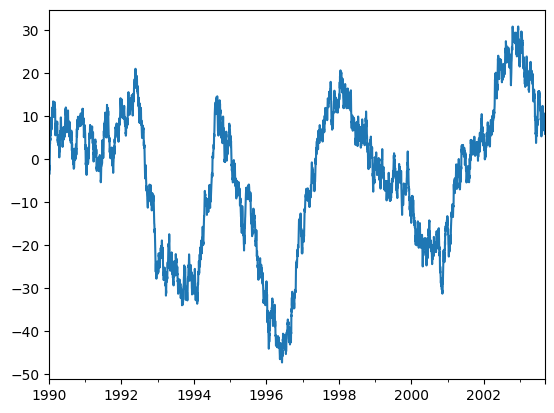

In [97]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [98]:
plt.show();

<Figure size 640x480 with 0 Axes>

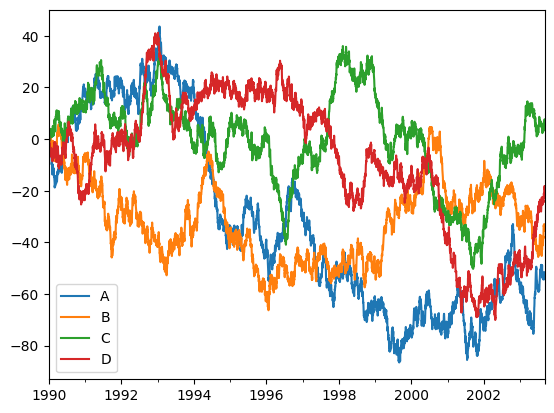

In [99]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [100]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [101]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,0.655850,-0.448883,-0.943711,0.195123
1,1990-01-02,-0.618054,-0.817717,-0.594383,1.264437
2,1990-01-03,-0.759529,-1.700455,-0.750736,0.818938
3,1990-01-04,0.216764,-2.010142,0.623685,0.355541
4,1990-01-05,-2.178383,-1.797806,-0.266290,0.268663
...,...,...,...,...,...
4995,2003-09-05,-53.973959,-33.591364,7.674085,-18.345427
4996,2003-09-06,-53.694682,-34.017998,5.290398,-18.357458
4997,2003-09-07,-52.763109,-35.469822,5.871923,-19.575164
4998,2003-09-08,-52.825995,-35.327385,4.835732,-18.794441


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [102]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [103]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,0.655850,-0.448883,-0.943711,0.195123
1990-01-02,-0.618054,-0.817717,-0.594383,1.264437
1990-01-03,-0.759529,-1.700455,-0.750736,0.818938
1990-01-04,0.216764,-2.010142,0.623685,0.355541
1990-01-05,-2.178383,-1.797806,-0.266290,0.268663
...,...,...,...,...
2003-09-05,-53.973959,-33.591364,7.674085,-18.345427
2003-09-06,-53.694682,-34.017998,5.290398,-18.357458
2003-09-07,-52.763109,-35.469822,5.871923,-19.575164
2003-09-08,-52.825995,-35.327385,4.835732,-18.794441


##Excel

Reading & writing to Excel.

Writing to an excel file using `DataFrame.to_excel()`:

In [104]:
df.to_excel("foo.xlsx", sheet_name="Sheet1")

In [105]:
pd.read_excel("foo.xlsx", "Sheet1", index_col=None, na_values=["NA"])

,Unnamed: 0,A,B,C,D
0,1990-01-01,0.655850,-0.448883,-0.943711,0.195123
1,1990-01-02,-0.618054,-0.817717,-0.594383,1.264437
2,1990-01-03,-0.759529,-1.700455,-0.750736,0.818938
3,1990-01-04,0.216764,-2.010142,0.623685,0.355541
4,1990-01-05,-2.178383,-1.797806,-0.266290,0.268663
...,...,...,...,...,...
4995,2003-09-05,-53.973959,-33.591364,7.674085,-18.345427
4996,2003-09-06,-53.694682,-34.017998,5.290398,-18.357458
4997,2003-09-07,-52.763109,-35.469822,5.871923,-19.575164
4998,2003-09-08,-52.825995,-35.327385,4.835732,-18.794441


##Series
a one-dimensional labeled array capable of holding any data type(integers, strings, ..etc)

`s = pd.Series(data, index=index)`


###**From ndarray**

If `data` is an ndarray, index must be the same length as data. If no index is passed, one will be created having values `[0, ..., len(data) - 1]`.

In [106]:
# From ndarray
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
s

a    0.435667
b    0.487502
c    0.044777
d   -0.797039
e    0.248659
dtype: float64

In [107]:
s.index

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [108]:
pd.Series(np.random.randn(5))

0    1.037280
1   -1.814976
2   -0.405286
3   -1.685589
4   -0.307321
dtype: float64

**From dict**
`Series` can be instantiated from dicts:

In [109]:
d = {"d":1, "a": 0, "c": 2}
pd.Series(d)

d    1
a    0
c    2
dtype: int64

In [110]:
# If an index is passed, the values in data corresponding to the labels in the index will be returned:

d = {"a": 0.0, "b": 1.0, "c": 2.0}

pd.Series(d)

a    0.0
b    1.0
c    2.0
dtype: float64

In [111]:
pd.Series(d, index=["b", "c", "d", "a"])

b    1.0
c    2.0
d    NaN
a    0.0
dtype: float64

**From scalar value**

If `data` is a scalar value, an index must be provided. The value will be repeated to match the length of the index.

In [112]:
pd.Series( '5a', index=["a", "b", "c", "d", "e"])

a    5a
b    5a
c    5a
d    5a
e    5a
dtype: object

In [113]:
s[s>s.median()]

a    0.435667
b    0.487502
dtype: float64

In [114]:

import openpyxl
import xlrd
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls")

,TABLE 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"SALIENT CEMENT STATISTICS1, 2",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(Thousand metric tons unless otherwise specified),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2014.0,2015.0,2016.0,2017.0,2018.0
5,United States:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Production:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cement3,NaN,NaN,82535.0,84405.0,84695.0,86356.0,86400.0
8,Clinker,NaN,NaN,74372.0,76043.0,75633.0,76678.0,77112.0
9,"Shipments from mills and terminals:3, 4",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
def cfun(x):
    return int(x) if x else -1
    
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release.xlsx", "Table1", usecols="A,B:G", converters={"MyInts": cfun})

,"Table 1. Value of Construction Put in Place in the United States, Seasonally Adjusted Annual Rate",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,(Millions of dollars. Details may not add to t...,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72,"lodging, religious, communication, and manufac...",NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,"Data are at an annual rate, adjusted for seaso...",NaN,NaN,NaN,NaN,NaN,NaN
75,Table 3 provides estimated measures of samplin...,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
bb = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release1.xlsx", "Sheet1", dtype={"MyInts": "Int64Dtype()", "MyText": str})
bb

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1


In [117]:
bb.dropna()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1
10,Health care,55756,55646,55869,55157,52848,49593,0.2,12.4
11,Educational,104598,105281,105978,103429,98554,98413,-0.6,6.3
12,Religious,3057,2920,2837,2707,3047,2750,4.7,11.2


In [118]:
bb[bb.columns[:9]].dtypes

Unnamed: 0                         object
Unnamed: 1                         object
Unnamed: 2                         object
Unnamed: 3                         object
Unnamed: 4                         object
Unnamed: 5                         object
Unnamed: 6                         object
Percent change\nJan 2023 from -    object
Unnamed: 8                         object
dtype: object

In [149]:
# pip install pytorch-forecasting
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

# load data
data = ...

# define dataset
max_encoder_length = 36
max_prediction_length = 6
training_cutoff = "YYYY-MM-DD"  # day for cutoff

training = TimeSeriesDataSet(
    data[lambda x: x.date < training_cutoff],
    time_idx= ...,
    target= ...,
    # weight="weight",
    group_ids=[ ... ],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[ ... ],
    static_reals=[ ... ],
    time_varying_known_categoricals=[ ... ],
    time_varying_known_reals=[ ... ],
    time_varying_unknown_categoricals=[ ... ],
    time_varying_unknown_reals=[ ... ],
)

# create validation and training dataset
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

# define trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    gradient_clip_val=0.1,
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback],
)

# create the model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# find optimal learning rate (set limit_train_batches to 1.0 and log_interval = -1)
res = Tuner(trainer).lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# fit the model
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

TypeError: ignored

##PyTorch Forecasting
**Building a simple first model**

Starting witha simple fully connected model, it'll take a timeseries of size `input_size` as input and outputs a new timeseries of size `output_size`. 

In [145]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

SyntaxError: ignored

In [120]:
import torch
from torch import nn

class FullyConnectedModule(nn.Module):
  def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int):
    super().__init__()

    # input layer
    module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
    # hidden layers
    for _ in range(n_hidden_layers):
        module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
    # output layer
    module_list.append(nn.Linear(hidden_size, output_size))

    self.sequential = nn.Sequential(*module_list)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      # x of shape: batch_size x n_timesteps_in
      # output of shape batch_size x n_timesteps_out
      return self.sequential(x)

# test that network works as intended
network = FullyConnectedModule(input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x = torch.rand(20, 5)
network(x).shape

torch.Size([20, 2])

The above model is not yet a PyTorch Forecasting model but it is easy to get there. As this is a simple model, we will use the `BaseModel`. This base class is modified `LightningModule` with pre-defined hooks for training and validating time series models. The main requirement is for the model to have a forward method.

In [144]:
def forward(self, x:
    # x is a batch generated based on the TimeSeriesDataset, here we just use the
    # continuous variables for the encoder
    network_input = x["encoder_cont"].squeeze(-1)
    prediction = self.linear(network_input)  #

    # rescale predictions into target space
    prediction = self.transform_output(prediction, target_scale=x["target_scale"])

    # We need to return a dictionary that at least contains the prediction
    # The parameter can be directly forwarded from the input.
    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
    return self.to_network_output(prediction=prediction)

SyntaxError: ignored

In [124]:
from typing import Dict

from pytorch_forecasting.models import BaseModel

class FullyConnectedModule(BaseModel):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a dictionary that at least contains the prediction
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

##Passing data to a model

Instead of having to write our own dataloader, we can leverage PyTorch Forecasting’s `TimeSeriesDataSet` to feed data to our model. In fact, PyTorch Forecasting expects us to use a `TimeSeriesDataSet`.

The data has to be in a specific format to be used by the `TimeSeriesDataSet`. It should be in a pandas DataFrame and have a categorical column to identify each series and a integer column to specify the time of the record.

Below, we create such a dataset with 30 different observations - 10 for 3 time series.

In [125]:
import numpy as np
import pandas as pd

test_data = pd.DataFrame(
    dict(
        value=np.random.rand(30) -0.5,
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
test_data 

,value,group,time_idx
0,-0.222055,0,0
1,-0.338348,0,1
2,-0.126813,0,2
3,-0.413531,0,3
4,-0.137129,0,4
5,-0.180845,0,5
6,0.049129,0,6
7,0.417954,0,7
8,-0.170682,0,8
9,0.285541,0,9


We can convert it to a `TimeSeriesDataSet` easily.

In [126]:
from pytorch_forecasting import TimeSeriesDataSet

# create the dataset from the pandas dataframe
dataset = TimeSeriesDataSet(
    test_data,
    group_ids=["group"],
    target="value",
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
)

We can take a look at all the defaults and settings preset by PyTorch Forecasting. These are all available as arguments in `TimeSeriesDataSet`.

In [127]:
dataset.get_parameters()

{'time_idx': 'time_idx',
 'target': 'value',
 'group_ids': ['group'],
 'weight': None,
 'max_encoder_length': 5,
 'min_encoder_length': 5,
 'min_prediction_idx': 0,
 'min_prediction_length': 2,
 'max_prediction_length': 2,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['value'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': GroupNormalizer(
 	method='standard',
 	groups=[],
 	center=True,
 	scale_by_group=False,
 	transformation=None,
 	method_kwargs={}
 ),
 'categorical_encoders': {'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True),
  'group': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers': {},
 'randomize_length': None,
 'predict_mode': False}

Now when we take a look at the output of the dataloader. It's `x` will be fed to the model's forward method.

In [128]:
# convert the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=4)

# and load the first batch
x, y = next(iter(dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

x = {'encoder_cat': tensor([], size=(4, 5, 0), dtype=torch.int64), 'encoder_cont': tensor([[[ 0.9777],
         [ 0.5660],
         [ 0.8328],
         [ 0.7202],
         [-0.5422]],

        [[ 0.7585],
         [-0.4074],
         [ 1.3363],
         [ 0.9777],
         [ 0.5660]],

        [[-0.5372],
         [-1.5099],
         [-0.5722],
         [-0.7205],
         [ 0.0596]],

        [[ 1.3363],
         [ 0.9777],
         [ 0.5660],
         [ 0.8328],
         [ 0.7202]]]), 'encoder_target': tensor([[ 0.3197,  0.1984,  0.2770,  0.2438, -0.1283],
        [ 0.2552, -0.0885,  0.4255,  0.3197,  0.1984],
        [-0.1268, -0.4135, -0.1371, -0.1808,  0.0491],
        [ 0.4255,  0.3197,  0.1984,  0.2770,  0.2438]]), 'encoder_lengths': tensor([5, 5, 5, 5]), 'decoder_cat': tensor([], size=(4, 2, 0), dtype=torch.int64), 'decoder_cont': tensor([[[ 0.0104],
         [ 0.8564]],

        [[ 0.8328],
         [ 0.7202]],

        [[ 1.3108],
         [-0.6861]],

        [[-0.5422],
   

Weight by samples for training:

In [129]:
from torch.utils.data import WeightedRandomSampler

# length of probabilties for sampler have to be equal to the length of the index
probabilities = np.sqrt(1 + data.loc[dataset.index, "target"])
sampler = WeightedRandomSampler(probabilities, len(probabilities))
dataset.to_dataloader(train=True, sampler=sampler, shuffle=False)

NameError: ignored

In [131]:
def forward(self, x:Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    # x is a batch generated based on the TimeSeriesDataset
    network_input = x["encoder_cont"].squeeze(-1)
    prediction = self.network(network_input)

    # rescale predictions into target space
    prediction = self.transform_output(prediction, target_scale=x["target_scale"])

    # We need to return a dictionary that at least contains the prediction
    # The parameter can be directly forwarded from the input.
    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
    return self.to_network_output(prediction=prediction)

In [133]:
model = FullyConnectedModel.from_dataset(dataset, input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x, y = next(iter(dataloader))
model(x)

NameError: ignored

In [134]:
dataset.x_to_index(x)

,time_idx,group
0,8,2
1,5,2
2,7,0
3,7,2


**Coupling datasets and models**

In [135]:
class FullyConnectedModel(BaseModel):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x:Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input).unsqueeze(-1)

        #rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        #We need to return a dictionary that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversation to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        new_kwargs ={
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(kwargs)  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert dataset.max_prediction_length == dataset.min_prediction_length, "Decoder only supports a fixed length"
        assert dataset.min_encoder_length == dataset.max_encoder_length, "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
            and dataset.time_varying_unknown_reals[0] == dataset.target
        ), "Only covariate should be the target in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)

Let's initialize from our dataset:

In [136]:
from lightning.pytorch.utilities.model_summary import ModelSummary

model = FullyConnectedModel.from_dataset(dataset, hidden_size=10, n_hidden_layers=2)
print(ModelSummary(model, max_depth=-1))
model.hparams

RecursionError: ignored

##Defining additional hyperparameters

So far, we have 

In [137]:
model.hparams

NameError: ignored

In [138]:
print(BaseModel.__init__.__doc__)


        BaseModel for timeseries forecasting from which to inherit from

        Args:
            log_interval (Union[int, float], optional): Batches after which predictions are logged. If < 1.0, will log
                multiple entries per batch. Defaults to -1.
            log_val_interval (Union[int, float], optional): batches after which predictions for validation are
                logged. Defaults to None/log_interval.
            learning_rate (float, optional): Learning rate. Defaults to 1e-3.
            log_gradient_flow (bool): If to log gradient flow, this takes time and should be only done to diagnose
                training failures. Defaults to False.
            loss (Metric, optional): metric to optimize, can also be list of metrics. Defaults to SMAPE().
            logging_metrics (nn.ModuleList[MultiHorizonMetric]): list of metrics that are logged during training.
                Defaults to [].
            reduce_on_plateau_patience (int): patience after which 

##Classification

In [139]:
classification_test_data = pd.DataFrame(
    dict(
        target=np.random.choice(["A", "B", "C"], size=30), #CHANGING values to predict to a categorical
        value=np.random.rand(30), # INPUT values
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
classification_test_data

,target,value,group,time_idx
0,C,0.931793,0,0
1,C,0.579574,0,1
2,C,0.386320,0,2
3,A,0.389395,0,3
4,A,0.347352,0,4
5,C,0.624916,0,5
6,B,0.923788,0,6
7,C,0.687417,0,7
8,B,0.515740,0,8
9,C,0.220297,0,9


In [140]:
from pytorch_forecasting.data.encoders import NaNLabelEncoder

# create the dataset from the pandas dataframe
classification_dataset = TimeSeriesDataSet(
    classification_test_data,
    group_ids=["group"],
    target="target",  # SWITCHING to categorical target
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
    target_normalizer=NaNLabelEncoder(),  # Use the NaNLabelEncoder to encode categorical target
)

x, y = next(iter(classification_dataset.to_dataloader(batch_size=4)))
y[0]  # target values are encoded categories

tensor([[1, 2],
        [0, 1],
        [2, 1],
        [1, 0]])

In [143]:
from pytorch_forecasting.metrics import CrossEntropy


class FullyConnectedClassificationModel(BaseModel):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        n_classes: int,
        loss=CrossEntropy(),
        **kwargs,
    ):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size * self.hparams.n_classes,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        batch_size = x["encoder_cont"].size(0)
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)
        # RESHAPE output to batch_size x n_decoder_timesteps x n_classes
        prediction = prediction.unsqueeze(-1).view(batch_size, -1, self.hparams.n_classes)

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a named tuple that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        assert isinstance(dataset.target_normalizer, NaNLabelEncoder), "target normalizer has to encode categories"
        new_kwargs = {
            "n_classes": len(
                dataset.target_normalizer.classes_
            ),  # ADD number of classes as encoded by the target normalizer
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(kwargs)  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert dataset.max_prediction_length == dataset.min_prediction_length, "Decoder only supports a fixed length"
        assert dataset.min_encoder_length == dataset.max_encoder_length, "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
        ), "Only covariate should be in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)


model = FullyConnectedClassificationModel.from_dataset(classification_dataset, hidden_size=10, n_hidden_layers=2)
print(ModelSummary(model, max_depth=-1))
model.hparams

RecursionError: ignored

# New section